In [1]:
import pandas as pd
import numpy as np
import os
import GPy
import contextlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

### Read in synthetic data

In [2]:
folder_path = '/Users/pmzff/Documents/GitHub/ModularCircFF/Emulation'

In [3]:
# Read Input Data
df_x = pd.read_csv(f'{folder_path}/Input/input_100.csv')

# Select varying inputs only
#columns_with_multiple_values = df_x.nunique() > 1
#filtered_input = df_x.loc[:, columns_with_multiple_values]

# Select only first 5 inputs 
filtered_input = df_x.iloc[:,:5]

dataframes = {}

# Read PCA data
for i in range(3):
    df_name = f'y_PC{i+1}'  # Create the dataframe name
    dataframes[df_name] = pd.read_csv(f'{folder_path}/Outputs/Out_fixed/PCA/PC{i+1}.csv')  # Read and store the dataframe
    
PC1 = dataframes['y_PC1']
PC2 = dataframes['y_PC2']
PC3 = dataframes['y_PC3']

df_pressure = pd.read_csv(f'{folder_path}/Outputs/Out_fixed/pressure_traces_r_pat/all_pressure_traces.csv')

CO = df_pressure.iloc[:,100:101]
dt = df_pressure['dt']
mean_press = df_pressure.iloc[:,:100].mean(axis=1).to_frame(name='mean_press')
max_press = df_pressure.iloc[:,:100].max(axis=1).to_frame(name='max_press')
min_press = df_pressure.iloc[:,:100].min(axis=1).to_frame(name='min_press')


### Take a look and input true input X 

In [4]:
filtered_input

,# svn.c,pat.r,pat.c,rv.E_act,T
0,27.687002,0.443723,3.278327,1.623082,0.478369
1,10.935100,0.243385,4.286711,2.717826,0.805784
2,18.671167,0.356841,2.549143,0.822205,0.950488
3,24.992088,0.155291,5.101243,3.333386,0.614289
4,22.700741,0.326891,3.862239,2.779415,0.551895
...,...,...,...,...,...
95,27.406567,0.196824,3.333852,1.704984,0.646159
96,26.960391,0.395660,2.043640,0.645535,0.810764
97,10.379113,0.271468,5.547834,3.156299,0.473453
98,17.956148,0.327547,3.782205,1.440794,0.618088


### Create vector of observations, y

In [5]:
combined_outptut_data = pd.concat([PC1, PC2, PC3, CO, max_press], axis=1)
combined_outptut_data

,PC1,PC2,PC3,CO,max_press
0,14.672208,-1.820989,-0.242595,3.562928,31.023888
1,-4.957084,0.857850,-1.151066,3.927774,22.766915
2,1.729320,2.687650,3.080620,3.299307,28.992385
3,-17.616349,-1.624573,-0.841759,3.877907,14.946666
4,4.124239,-0.868110,-0.813737,3.838552,25.967403
...,...,...,...,...,...
95,-13.008117,0.123681,0.457627,3.777376,18.757382
96,4.072604,2.115061,3.988298,3.206075,30.445996
97,-0.066577,-2.343926,-1.035500,4.117032,22.751738
98,3.896077,-1.031787,0.695567,3.801754,26.389662


### Import linear models for each output we are calibrating

In [6]:
# Read in dataframe of fitted linear models
model_dataframes = pd.read_pickle(f'{folder_path}/Outputs/Emulators/linear_models_and_r2_scores.csv')

selected_rows = model_dataframes.loc[['y_PC1', 'y_PC2', 'y_PC3', 'CO', 'max_press']]
selected_rows

,R2_Score,Model
y_PC1,0.987922,LinearRegression()
y_PC2,0.882277,LinearRegression()
y_PC3,0.647736,LinearRegression()
CO,0.940900,LinearRegression()
max_press,0.980859,LinearRegression()


### Conduct the inverse problem i.e. calibrate the model for X
Remember this is the minimum norm solution of X

In [36]:
# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

# Selects which observation to calibrate on
which_obs = 10

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

# Select observation and reshape to be (d, 1)
Y_obs = np.array(combined_outptut_data.T[which_obs])
Y_obs = Y_obs.reshape(len(Y_obs), 1)

# Scale observation by intercepts of models
Y_scaled = Y_obs - intercept

# Compute the pseudo-inverse of the coefficient matrix
beta_inv = np.linalg.inv(beta_matrix.T @ beta_matrix) @ beta_matrix.T
x_hat = beta_inv @ Y_scaled


In [37]:
# Convert the calibrated inputs to a DataFrame
x_hat_df = pd.DataFrame(x_hat, index=filtered_input.iloc[which_obs].T.index)

# Concatenate the true input value and calibrated values
result = pd.concat([filtered_input.iloc[which_obs].T, x_hat_df], axis=1)

# Rename the columns
result.columns = ['x_true', 'x_calibrated']

result


,x_true,x_calibrated
# svn.c,16.843858,36.685974
pat.r,0.447749,0.451915
pat.c,4.127918,2.991178
rv.E_act,1.859428,2.627498
T,0.671982,0.416907


In [9]:
pd.DataFrame(x_hat, index=filtered_input.iloc[which_obs].T.index)

,0
# svn.c,-69.304120
pat.r,0.417955
pat.c,10.419542
rv.E_act,-1.026730
T,1.610189


In [10]:
result.to_csv('multiple_output_calibration_result_x.csv')

### Check that calibrated X can recover original observational data.  

In [11]:
# Feed calibrated x_hat back into linear model 
y_calibrated = (beta_matrix @ x_hat) + intercept 

y_compare = np.hstack([Y_obs, y_calibrated])
y_compare = pd.DataFrame(y_compare)
y_compare.columns = ("y_true", "y_calibrated")

y_compare.to_csv('multiple_output_calibration_result_y.csv', index=False)

In [12]:
y_compare

,y_true,y_calibrated
0,14.672208,14.672208
1,-1.820989,-1.820989
2,-0.242595,-0.242595
3,3.562928,3.562928
4,31.023888,31.023888


Calibrate multiple observations and calculate MSE

In [47]:
# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

x_differences = []

for row in range(10):
 # Select observation and reshape to be (d, 1)
 Y_obs = np.array(combined_outptut_data.T[row])
 Y_obs = Y_obs.reshape(len(Y_obs), 1)

 # Scale observation by intercepts of models
 Y_scaled = Y_obs - intercept

 # Compute the pseudo-inverse of the coefficient matrix
 beta_inv = np.linalg.inv(beta_matrix.T @ beta_matrix) @ beta_matrix.T
 x_hat = beta_inv @ Y_scaled

 # Compute squared-diff between true and calibrated x
 true = np.array(filtered_input.loc[row].T)
 true = true.reshape(5,1)
 diff = (x_hat - true)**2

 # Append arrary
 x_differences.append(diff)

# Compute MSE
mse_x = np.mean(np.hstack(x_differences), axis=1)

mse_x_df = pd.DataFrame(mse_x)
mse_x_df.columns = ['MSE']
mse_x_df.index = filtered_input.columns
mse_x_df.to_csv('MSE_multi_output_x.csv')

mse_x_df

true: [[27.68700208]
 [ 0.44372346]
 [ 3.27832684]
 [ 1.62308171]
 [ 0.47836946]], x_hat: [[-69.30411971]
 [  0.4179547 ]
 [ 10.41954238]
 [ -1.02672999]
 [  1.61018867]] Diff: [9407.27770615]
true: [[10.93510017]
 [ 0.24338452]
 [ 4.28671105]
 [ 2.71782557]
 [ 0.8057836 ]], x_hat: [[-11.47008241]
 [  0.23719321]
 [  5.98856303]
 [  2.13083938]
 [  1.05645248]] Diff: [501.99220658]
true: [[18.67116667]
 [ 0.35684107]
 [ 2.5491431 ]
 [ 0.8222047 ]
 [ 0.95048822]], x_hat: [[ 1.03792952e+02]
 [ 3.77115211e-01]
 [-3.69232636e+00]
 [ 2.49329609e+00]
 [-7.75103204e-02]] Diff: [7245.71833152]
true: [[24.99208756]
 [ 0.15529119]
 [ 5.10124261]
 [ 3.33338613]
 [ 0.61428876]], x_hat: [[-16.78978103]
 [  0.13859679]
 [  7.68830034]
 [  1.31089869]
 [  1.12457322]] Diff: [1745.72454285]
true: [[22.70074085]
 [ 0.32689122]
 [ 3.86223855]
 [ 2.77941513]
 [ 0.5518949 ]], x_hat: [[55.529966  ]
 [ 0.34282285]
 [ 1.68145052]
 [ 3.83235199]
 [ 0.12721979]] Diff: [1077.75802379]
true: [[16.1990346 ]
 [ 0.

,MSE
# svn.c,4581.203286
pat.r,0.000582
pat.c,22.615799
rv.E_act,4.106932
T,0.663989


### Calculate the SVD of $\beta$

In [14]:
U, S, V=np.linalg.svd(beta_matrix)

In [15]:
pd.DataFrame(beta_matrix)

,0,1,2,3,4
0,-0.304958,101.815893,-1.501709,1.135405,-11.147692
1,-0.047743,-0.314719,-1.542643,0.750891,6.904545
2,-0.001013,-1.918926,-0.444365,-1.113743,-0.633882
3,-0.025551,-1.822092,-0.118590,0.098169,-1.223962
4,-0.186423,48.765475,-2.040865,0.584967,-0.811602


In [16]:
pd.DataFrame(S)

,0
0,113.432075
1,8.364263
2,1.293610
3,0.518454
4,0.001776


In [17]:
# Check rank
tolerance = 1e-12
is_full_rank = np.all(S > tolerance)

print("Is the matrix full rank?", is_full_rank)

Is the matrix full rank? True


### Bayesian Calibration  
Assuming we have the following linear regression model $$y = \beta X + \epsilon_d,$$ where $$\epsilon_d \sim N_p(0, \sigma^2I)$$ and $I$ is the $d$-dimensional identity matrix. Here $d=5$, the dimension of $X$. To be explicit, $dim(y) = dim(X) = 5$ and $dim(\beta) = (5,5)$.

Then it follows that we have the distribution $$y|X \sim N(\mu, \Sigma)$$ where $$\mu = \beta X , \Sigma = \sigma^2I.$$

We will put priors on the parameters we are trying to infer. The input parameters $X$ were sampled uniformly from the table below. However, for simplicity, I will put a Gaussian prior on each parameter such that approximately 99% of the data is accounted for within 3 standard deviations of the mean. The priors are as follows.

| Parameter    | Point Estimate| Scaling Factor (Min) | Scaling Factor (Max) | Prior |
|:-------------|:------:|:-------:|:-------:| :------: |
| $C_{svn}$    | 20.5   | 0.5     | 1.5     |   $C_{svn} \sim N(20.5, 3.42)$      |
| $R_{pat}$    | 0.31   | 0.5     | 1.5     |   $R_{pat} \sim N(0.31, 0.05)$      |
| $C_{pat}$    | 3.8    | 0.5     | 1.5     |   $C_{pat} \sim N(0.38, 0.63)$      |
| $rv.E{act}$  | 1.15   | 0.5     | 3       |   $rv.E_{act} \sim N(1.15, 0.48)$   |
| $T$          | 1      | 0.4     | 0.96    |   $T \sim N(1, 0.15)$               |

Thus our prior on $X$ is given by $X \sim MVN(\mu_0, \Sigma_0)$ where,  
$$ \mu_0 = \begin{bmatrix}
20.5 \\
0.31 \\
0.38 \\
1.15  \\
1 
\end{bmatrix} ,


\Sigma_0 = \begin{bmatrix}
3.42 & 0 & 0 & 0 & 0 \\
0 & 0.63 & 0 & 0 & 0  \\
0 & 0 & 0.05 & 0 & 0  \\
0 & 0 & 0 & 0.48 &  0 \\
0 & 0 & 0 & 0 & 0.15 
\end{bmatrix}
$$

The posterior distribution of $x|y$ is given as $$\pi(X|y) = \pi(y|X)\pi(X).$$ With some (omitted) calculations it can be shown that $$\pi(X|y) \sim N(\mu_{post}, \Sigma_{post})$$ where $$\mu_{post} = \Sigma_{post}\left(\frac{\beta^T y}{\sigma^2} + \Sigma_0^{-1}\mu_0\right)$$ and $$ \Sigma_{post} = \left( \frac{\beta^T\beta}{\sigma^2} + \Sigma_0^{-1}\right)^{-1}.$$

We will derive the above posterior means and standard deviation for our data. We assume that measurement error is know to have mean 0 and $\sigma^2 = 1$.

In [31]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 0.38
rv_mu = 1.15
t_mu = 1

# standard deviation
c_svn_sd = 3.42
r_pat_sd = 0.05
c_pat_sd = 0.63
rv_sd = 0.48
t_sd = 0.15

mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
Sigma_0 = np.diag(Sd)

# Build beta matrix (d * p, where d is dimension of y_obs and p is dimension of X)
beta_matrix = []
intercept = []

# Selects which observation to calibrate on
which_obs = 10

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

# Select observation and reshape to be (d, 1)
Y_obs = np.array(combined_outptut_data.T[which_obs])
Y_obs = Y_obs.reshape(len(Y_obs), 1)

# Scale observation by intercepts of models
Y_scaled = Y_obs - intercept

# Compute the posterior covariance
Sigma_post_inv = (beta_matrix.T @ beta_matrix) + np.linalg.inv(Sigma_0)
Sigma_post = np.linalg.inv(Sigma_post_inv)

# Cmpute the posterior mean
Mu_post = Sigma_post @ (beta_matrix.T @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)


In [56]:
# Convert the calibrated inputs to a DataFrame
Mu_post_df = pd.DataFrame(Mu_post, index=filtered_input.iloc[which_obs].T.index)

# Concatenate the true input value and calibrated values
bayes_result = pd.concat([filtered_input.iloc[which_obs].T, Mu_post_df], axis=1)

# Rename the columns
bayes_result.columns = ['x_true', 'x_calibrated']

bayes_result

,x_true,x_calibrated
# svn.c,16.843858,20.647383
pat.r,0.447749,0.192291
pat.c,4.127918,1.567820
rv.E_act,1.859428,1.999681
T,0.671982,0.617620


In [57]:
bayes_result.to_csv('bayesian_calibration_result_x.csv')

In [21]:
U, S, V=np.linalg.svd(Sigma_post)

In [22]:
V

array([[-9.99825745e-01, -2.92743227e-03,  1.81066537e-02,
        -2.87834405e-03, -1.94271707e-03],
       [-1.64251131e-02, -4.23256386e-02, -8.66409619e-01,
         4.46270254e-01, -2.19353568e-01],
       [-5.61286423e-03, -5.65744250e-04, -4.53760045e-01,
        -8.90888513e-01, -1.96889323e-02],
       [ 6.11963687e-03, -8.46842855e-02,  2.06711770e-01,
        -8.38085065e-02, -9.71101179e-01],
       [ 3.12109635e-03, -9.95504004e-01,  1.94572879e-02,
        -1.13299080e-02,  9.19515291e-02]])

Bayesian calibration of multiple observations and calculate MSE between true input value and the mean of the posterior distrubtion at each observation. 

In [51]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 0.38
rv_mu = 1.15
t_mu = 1

# standard deviation
c_svn_sd = 3.42
r_pat_sd = 0.05
c_pat_sd = 0.63
rv_sd = 0.48
t_sd = 0.15

mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
Sigma_0 = np.diag(Sd)

# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

x_differences = []

for row in range(10):
 # Select observation and reshape to be (d, 1)
 Y_obs = np.array(combined_outptut_data.T[row])
 Y_obs = Y_obs.reshape(len(Y_obs), 1)
 
 # Scale observation by intercepts of models
 Y_scaled = Y_obs - intercept


 # Compute the posterior covariance
 Sigma_post_inv = (beta_matrix.T @ beta_matrix) + np.linalg.inv(Sigma_0)
 Sigma_post = np.linalg.inv(Sigma_post_inv)

 # Cmpute the posterior mean
 Mu_post = Sigma_post @ (beta_matrix.T @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)

 # Compute squared-diff between true and calibrated x
 true = np.array(filtered_input.loc[row].T)
 true = true.reshape(5,1)
 diff = (Mu_post - true)**2 

 # Append arrary
 x_differences.append(diff)

# Compute MSE
bayes_mse_x = np.mean(np.hstack(x_differences), axis=1)

bayes_mse_x_df = pd.DataFrame(bayes_mse_x)
bayes_mse_x_df.columns = ['MSE']
bayes_mse_x_df.index = filtered_input.columns
bayes_mse_x_df.to_csv('MSE_multi_output_x.csv')

bayes_mse_x_df

,MSE
# svn.c,42.664935
pat.r,0.005301
pat.c,3.963797
rv.E_act,0.448164
T,0.132452


Comparison of MSE of bayesian calibration (above) and frequentist calibration (below)

In [53]:
mse_x_df

,MSE
# svn.c,4581.203286
pat.r,0.000582
pat.c,22.615799
rv.E_act,4.106932
T,0.663989


Visualise the posterior distribtuion

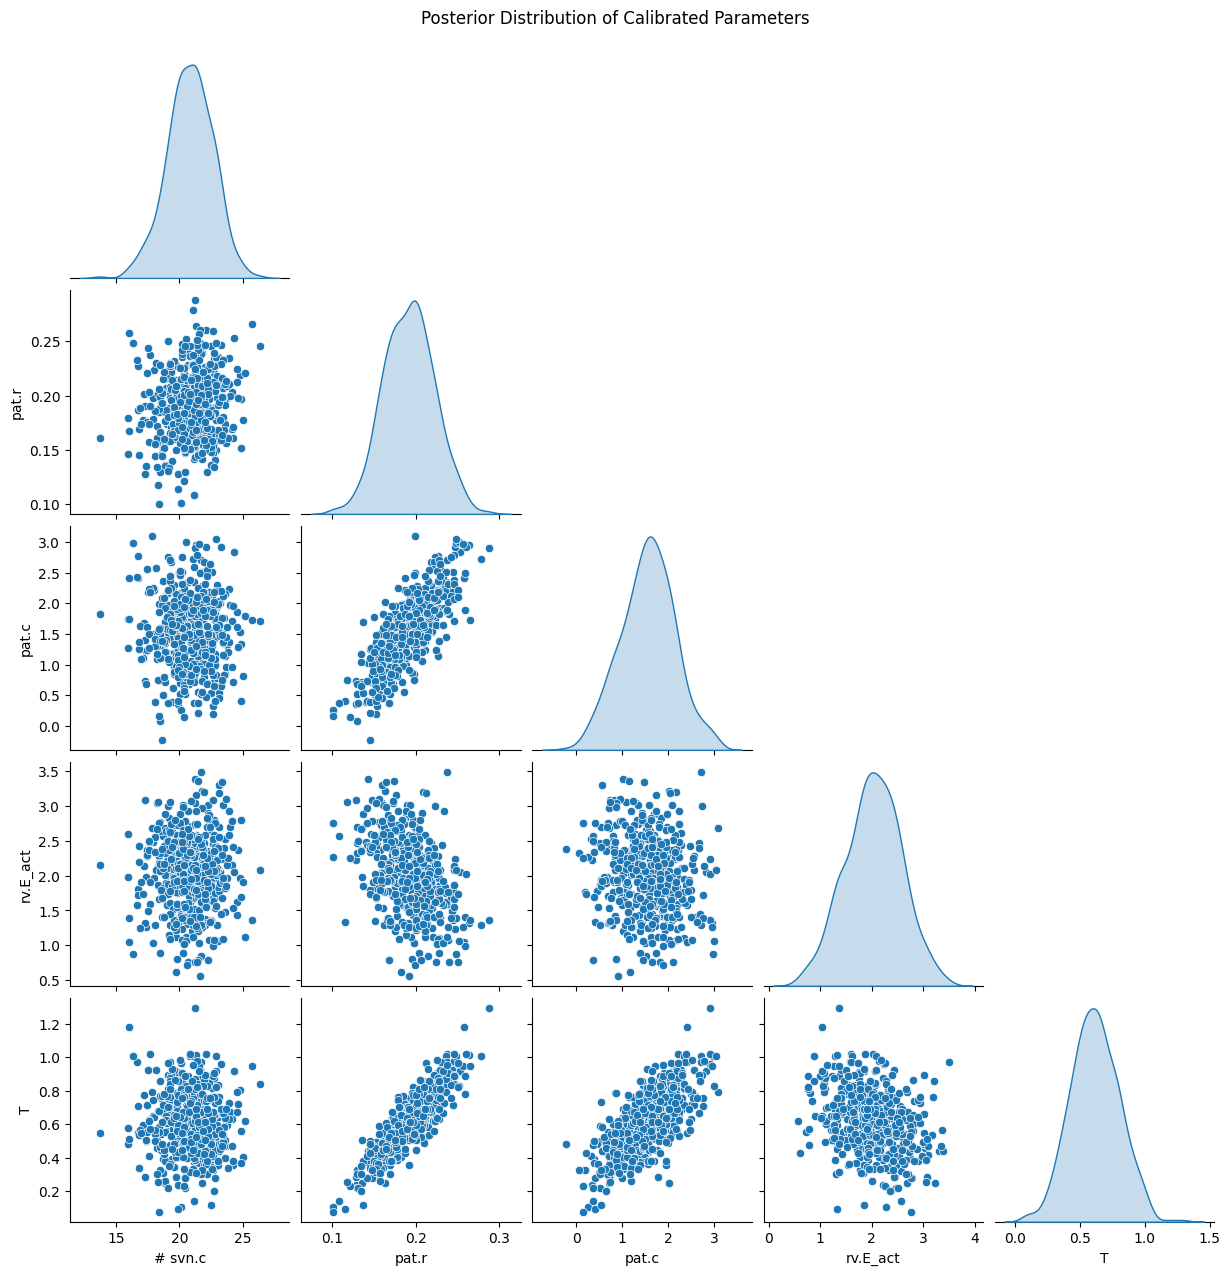

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

# Define the mean (mu) and covariance matrix (sigma)
mu = Mu_post.reshape(-1)
sigma = Sigma_post

parameter_names = mse_x_df.index.values.tolist()

# Generate random samples
rng = np.random.default_rng(1)  # Using your specific random generator seed
samples = rng.multivariate_normal(mu, sigma, size=500)

# Convert samples to a DataFrame for pairplot visualization
import pandas as pd
columns = [f"X{i+1}" for i in range(len(mu))]
df = pd.DataFrame(samples, columns=parameter_names)

# Pairplot visualization
sns.pairplot(df, diag_kind='kde', corner=True)
plt.suptitle("Posterior Distribution of Calibrated Parameters", y=1.02)
plt.show()